In [1]:
# -*- coding: utf-8 -*-
# @Author: Ultraice
# @Date:   2020-03-06
import cv2
import numpy as np
from matplotlib import pyplot as plt
import stereoconfig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg

In [2]:
 #Function to create point cloud file
def create_output(vertices, colors, filename): 
    colors = colors.reshape(-1, 3)
    vertices = np.hstack([vertices.reshape(-1, 3), colors])

    ply_header = '''ply
        format ascii 1.0
        element vertex %(vert_num)d
        property float x
        property float y
        property float z
        property uchar red
        property uchar green
        property uchar blue
        end_header
        '''

    with open(filename, 'w') as f:
        f.write(ply_header % dict(vert_num=len(vertices)))
        np.savetxt(f, vertices, '%f %f %f %d %d %d')

In [3]:
#读取矩阵参数
def getRectifyTransform(height, width, config):    
    left_K = config.cam_matrix_left
    right_K = config.cam_matrix_right
    left_distortion = config.distortion_l
    right_distortion = config.distortion_r
    R = config.R
    T = config.T

    #计算校正变换
    if type(height) != "int" or type(width) != "int":
        height = int(height)
        width = int(width)
    R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(left_K, left_distortion, right_K, right_distortion,
                                                      (width, height), R, T, alpha=0)
    map1x, map1y = cv2.initUndistortRectifyMap(left_K, left_distortion, R1, P1, (width, height), cv2.CV_32FC1)
    map2x, map2y = cv2.initUndistortRectifyMap(right_K, right_distortion, R2, P2, (width, height), cv2.CV_32FC1)

    return map1x, map1y, map2x, map2y, Q

In [4]:
# 绘制极线
def drawlines(img1, img2, lines, pts1, pts2):

    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''

    r, c = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1]])
        img1 = cv2.line(img1, (x0, y0), (x1, y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2

In [5]:
#SGBM参数设置
def sgbm(imgL, imgR):
    blockSize = 5
    img_channels = 3
    stereo = cv2.StereoSGBM_create(minDisparity=1,
                                   numDisparities=64,
                                   blockSize=blockSize,
                                   P1=8 * img_channels * blockSize * blockSize,
                                   P2=32 * img_channels * blockSize * blockSize,
                                   disp12MaxDiff=-1,
                                   preFilterCap=1,
                                   uniquenessRatio=10,
                                   speckleWindowSize=100,
                                   speckleRange=100,
                                   mode=cv2.STEREO_SGBM_MODE_HH)
    disp = stereo.compute(imgL, imgR)
    disp = np.divide(disp.astype(np.float32), 16.)#除以16得到真实视差图
    return disp

In [6]:
# 畸变校正和立体校正
def rectifyImage(image1, image2, map1x, map1y, map2x, map2y):
    rectifyed_img1 = cv2.remap(image1, map1x, map1y, cv2.INTER_AREA)
    rectifyed_img2 = cv2.remap(image2, map2x, map2y, cv2.INTER_AREA)
    return rectifyed_img1, rectifyed_img2

In [7]:
# 计算像素点的3D坐标（左相机坐标系下）
def threeD(disp, Q):

    points_3d = cv2.reprojectImageTo3D(disp, Q)
    points_3d = points_3d.reshape(points_3d.shape[0] * points_3d.shape[1], 3)

    X = points_3d[:, 0]
    Y = points_3d[:, 1]
    Z = points_3d[:, 2]

    #选择并删除错误的点
    remove_idx1 = np.where(Z <= 0)
    remove_idx2 = np.where(Z > 15000)
    remove_idx3 = np.where(X > 10000)
    remove_idx4 = np.where(X < -10000)
    remove_idx5 = np.where(Y > 10000)
    remove_idx6 = np.where(Y < -10000)
    remove_idx = np.hstack(
        (remove_idx1[0], remove_idx2[0], remove_idx3[0], remove_idx4[0], remove_idx5[0], remove_idx6[0]))

    points_3d = np.delete(points_3d, remove_idx, 0)
    return points_3d

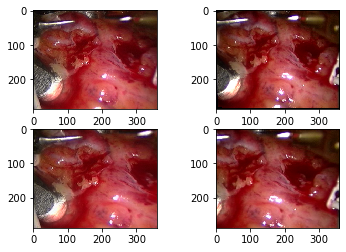

In [8]:
# 读取图片
img1path = 'D:/Python3/FeatureMatch/redressed1/ICur1_0001.bmp'
img2path = 'D:/Python3/FeatureMatch/redressed1/ICur2_0001.bmp'
imgL = mpimg.imread(img1path)  # left image
imgR = mpimg.imread(img2path)  # right image

height, width = imgL.shape[0:2]

# 读取相机内参和外参
config = stereoconfig.stereoCameral()

# 立体校正
map1x, map1y, map2x, map2y, Q = getRectifyTransform(height, width, config)
iml_rectified, imr_rectified = rectifyImage(imgL, imgR, map1x, map1y, map2x, map2y)

# 绘制图像
plt.subplot(221)
plt.imshow(imgL)
plt.subplot(222)
plt.imshow(imgR)
plt.subplot(223)
plt.imshow(iml_rectified)
plt.subplot(224)
plt.imshow(imr_rectified)
plt.show()

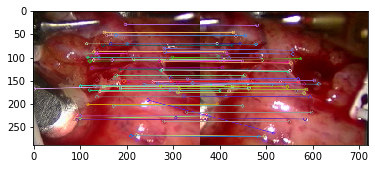

Matched Num: 80


In [9]:
# sift进行特征提取
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with sift
kp1, des1 = sift.detectAndCompute(iml_rectified, None)
kp2, des2 = sift.detectAndCompute(imr_rectified, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)
good = []
pts1 = []
pts2 = []

# ratio test as per Lowe's paper
for i, (m, n) in enumerate(matches):
    if m.distance < 0.7 * n.distance:
        good.append([m])
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
img_matched = cv2.drawMatchesKnn(iml_rectified, kp1, imr_rectified, kp2, good, None, flags=2)
plt.imshow(img_matched)
plt.show()
print('Matched Num:', len(pts1))

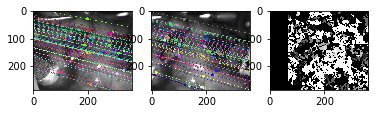

In [10]:
pts_int1 = np.int32(pts1)
pts_int2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts_int1, pts_int2, cv2.FM_RANSAC)
# print(F)
# print(mask.shape, pts1.shape)

# We select only inlier points
pts_int1 = pts_int1[mask.ravel() == 1]
pts_int2 = pts_int2[mask.ravel() == 1]

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts_int2.reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)

iml_rectified_gray = cv2.cvtColor(iml_rectified, cv2.COLOR_RGB2GRAY)
imr_rectified_gray = cv2.cvtColor(imr_rectified, cv2.COLOR_RGB2GRAY)
img5, img6 = drawlines(iml_rectified_gray, imr_rectified_gray, lines1, pts_int1, pts_int2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts_int1.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(imr_rectified_gray, iml_rectified_gray, lines2, pts_int2, pts_int1)

disparity_map = sgbm(iml_rectified, imr_rectified)
plt.subplot(131), plt.imshow(img5)
plt.subplot(132), plt.imshow(img3)
plt.subplot(133), plt.imshow(disparity_map, 'gray')
plt.show()

Num of points4D: 80


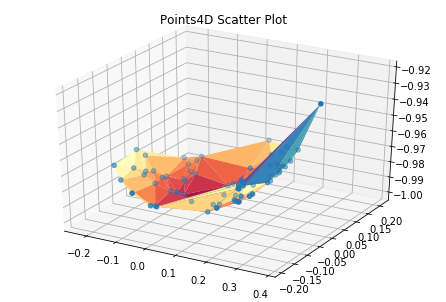

In [41]:
# 基于三角测量还原
P1 = np.array([[524.844130000000, 0., 217.173580000000, 0.],
               [0., 577.110240000000, 150.763790000000, 0.],
               [0.,                0.,                1, 0.]])
P2 = np.array([[524.520233073651, 7.52736070286657, 160.059379742608, 2970.80088985420],
               [-13.4461587284326, 582.512489166281, 156.250630493458, 39.9550566570000],
               [-0.0426087861184525, 0.00970718276166426, 0.999044674650910, 0.398860000000000]])
points4D = cv2.triangulatePoints(P1, P2, np.mat(pts1).T, np.mat(pts2).T, points4D=None)

from scipy.spatial import Delaunay
# import matplotlib.tri as mtri
# 点云可视化
X1 = []
Y1 = []
Z1 = []

for point in points4D.T:
    X1.append(point[0])
    Y1.append(point[1])
    Z1.append(point[2])

print("Num of points4D:", len(X1))
points = np.zeros((len(X1), 2))
points[:,0] = X1
points[:,1] = Y1
tri = Delaunay(points)


# 绘制散点图
fig = plt.figure()
ax1 = Axes3D(fig)
ax1.set_title('Points4D Scatter Plot')
ax1.plot_trisurf(X1, Y1, Z1, triangles=tri.simplices, cmap=plt.cm.Spectral)
ax1.scatter3D(X1, Y1, Z1, cmap='Blues')
plt.show()


 Creating the output file... 

Num of output_points: 42599


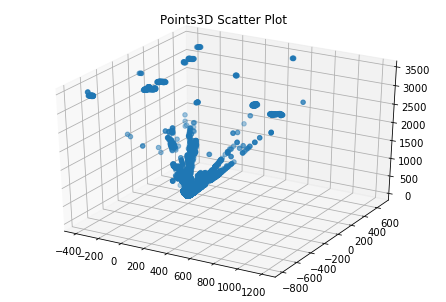

In [12]:
# 基于深度图还原
# Reproject points into 3D
points_3D = cv2.reprojectImageTo3D(disparity_map, Q)
# Get color points
colors = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

# Get rid of points with value 0 (i.e no depth)
mask_map = disparity_map > disparity_map.min()

# Mask colors and points.
output_points = points_3D[mask_map]
output_colors = colors[mask_map]

# Define name for output file
output_file = 'reconstructed.ply'

# Generate point cloud file
print("\n Creating the output file... \n")
create_output(output_points, output_colors, output_file)

# 点云可视化
X2 = []
Y2 = []
Z2 = []

for point in output_points:
    X2.append(point[0])
    Y2.append(point[1])
    Z2.append(point[2])

print("Num of output_points:", len(X2))
# 绘制散点图
fig = plt.figure()
ax2 = Axes3D(fig)
ax2.set_title('Points3D Scatter Plot')
ax2.scatter3D(X2, Y2, Z2, cmap='Reds')
plt.show()